# 프로젝트: 한영 번역기 만들기

#### import library

In [1]:
import os
import re
import random
from tqdm import tqdm    # tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf

#### matplotlib setting

In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 데이터 준비

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [3]:
path = "/workspace/userdisk/project/GoingDeeper/Go04/"
kor_file = path+"korean-english-park.train.ko"
eng_file = path+"korean-english-park.train.en"

In [4]:
# 한글
with open(kor_file, "r") as f:
    kor_raw = f.read().splitlines()

# 영어
with open(eng_file, "r") as f:
    eng_raw = f.read().splitlines()

print("kor_raw size: ", len(kor_raw))
print("eng_raw size: ", len(eng_raw))

for i, (kor, eng) in enumerate(zip(kor_raw, eng_raw)):
    if i % 10000 == 0:
        print("kor: ", kor)
        print("eng: ", eng)

kor_raw size:  94123
eng_raw size:  94123
kor:  개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
eng:  Much of personal computing is about "can you top this?"
kor:  그는 민주당 대선후보가 결정 될 때까지 경선을 계속 치르겠다는 뜻을 밝힌 바 있다.
eng:  Clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination.
kor:  세인트피터스버그의 편집국장인 빌 에데어는 “루디는 다우존스 산업지수 주가처럼 지지율이 떨어졌다”며 “그는 플로리다에 모든 승부수를 뒀으나 그 같은 전략은 실패한 것으로 보인다”고 말했다.
eng:  "Rudy has fallen like the Dow Jones industrial average," said Bill Adair, chief editor of the St. Petersburg Times. "What's happened is he gambled on Florida and put all his chips on Florida, and it's beginning to look like he gambled wrong."
kor:  존 데니 경찰서장은 피터슨이 어떻게 자살했는지 밝히진 않았지만 더 이상 주민들에게 위협을 주진 못할 것이라고 전했다.
eng:  Police Chief John Dennee would not say how Peterson died, but said he was "no longer a threat to the public."
kor:  두 부부의 개인 웹사이트에따르면 성 루이스 파크 미니애폴리스 교외에서 살고있는 모리슨 부부는 임신 촉진제를 이용하기 전 임신을 위해 1년 이상 시간을 보냈다.
eng:  The Morrisons, of the Minneapolis suburb of S

## 데이터 정제

- 중복 제거
- 여러개 쌍따옴표를 하나로 처리
- ?!,." -> 앞뒤 공백 추가  -> **쌍따옴표는 인용구 표현이므로 제거하지 않는다**
- 여러 개의 연속된 공백 -> 하나의 공백
- 영어 대소문자/?.!,"/한글/숫자 제외한 문제 제거 -> **한글, 숫자, \" 추가**
- 영어는 모두 소문자
- 양쪽 공백 제거


### 중복 제거

In [5]:
len(set(kor_raw))

77591

In [6]:
len(set(eng_raw))

75598

두 데이터 셋의 중복 갯수가 다름 -> 같은 한국어에 다른 영어가 존재함

In [7]:
df = pd.DataFrame({"kor": kor_raw,"eng": eng_raw})
df.sample(5)

,kor,eng
70551,잭슨 소장품 경매 장갑 최고가 낙...,"Glove, other Michael Jackson it..."
56563,수잔 보일 데뷔 음반 예약주문 1...,Susan Boyle's debut CD sets Ama...
3820,"美 해군 역사관 웹사이트에는 사물들, ""특히 우리에게 소중한 사물들""을 여성으로 분...",Naval Historical Center Web site says it is cu...
67015,"기후변화의 피해자, 개도국 여성",Women 'bearing brunt' of climat...
4657,이 책의 발매는 인터넷 도서 소매업체인 아마존닷컴이 100만부가 넘는 주문을 이미 ...,The launch of the book is so hotly anticipated...


In [8]:
df[df.duplicated(keep=False)].sort_values(by="kor")

,kor,eng
50523,"""그것은 정말 도전적인 연극이며 만약 내가 성공을 거둘 수 있다면-아직 그럴 수 있...","""It's a really challenging play, and if I can ..."
51567,"""그것은 정말 도전적인 연극이며 만약 내가 성공을 거둘 수 있다면-아직 그럴 수 있...","""It's a really challenging play, and if I can ..."
51045,"""그것은 정말 도전적인 연극이며 만약 내가 성공을 거둘 수 있다면-아직 그럴 수 있...","""It's a really challenging play, and if I can ..."
50262,"""그것은 정말 도전적인 연극이며 만약 내가 성공을 거둘 수 있다면-아직 그럴 수 있...","""It's a really challenging play, and if I can ..."
50001,"""그것은 정말 도전적인 연극이며 만약 내가 성공을 거둘 수 있다면-아직 그럴 수 있...","""It's a really challenging play, and if I can ..."
...,...,...
72183,힐러리 이날 청문회를 마쳤다.,Clinton completed her testimony on Tuesday.
93792,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
79517,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
64666,힐러리 클린턴은 지난 2001년 1월 이후 상원의원에 재임 중이다.,Hillary Clinton has been in the Senate since J...


#### kor, eng 둘 다 중복인 행 삭제

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(78968, 2)

In [11]:
df.groupby('kor').filter(lambda x: len(x) >= 3).sort_values(by="kor")

,kor,eng
67260,(CNN) / 이수지(JOINS),How did you get this project?
63192,(CNN) / 이수지(JOINS),How might we find out?
54843,(CNN) / 이수지(JOINS),"""He's a fantastic talent."""
55603,(CNN) / 이수지(JOINS),"They've got good hitters."""
71782,(CNN) / 이수지(JOINS),"""I'd like to put it in the past now."
...,...,...
61390,해수욕장에서 점프하는 상어 순간.. 해수욕장에서 점프하는 상어 순간..,"""Slumdog,"" which opened Friday in limited rele..."
53081,해수욕장에서 점프하는 상어 순간.. 해수욕장에서 점프하는 상어 순간..,"That is a fairly good outcome, given the fragi..."
54317,해수욕장에서 점프하는 상어 순간.. 해수욕장에서 점프하는 상어 순간..,The crews aim to prevent the blazes from pushi...
55386,해수욕장에서 점프하는 상어 순간.. 해수욕장에서 점프하는 상어 순간..,"""Gilles was hitting much better from behind th..."


한국어가 3개 이상 중복인 경우, 데이터가 이상한 데이터로 판단하여 삭제한다.

In [12]:
drop_index = df.groupby('kor').filter(lambda x: len(x) >= 3).sort_values(by="kor").index

In [13]:
df.drop(drop_index, inplace=True)

In [14]:
df[df.duplicated("kor", keep=False)].sort_values(by="kor")

,kor,eng
35738,(CNN)/권성근(JOINS),"""Please don't use force."
36146,(CNN)/권성근(JOINS),Two Germans were also kidnapped last week.
65519,1999년 옥스퍼드 졸업생들이 설립한 옥스브리지 입시학원(Oxbridge Appli...,"In the United Kingdom, 90 percent of students ..."
65506,1999년 옥스퍼드 졸업생들이 설립한 옥스브리지 입시학원(Oxbridge Appli...,Tutoring company Oxbridge Applications founded...
67596,2005년 이 프로그램 시판되면서 일본에서는 정신건강에 대해 열광하기 시작했다.,The launch of the program in 2005 kicked off t...
...,...,...
32234,호츠(17)는 해킹을 통해 조작한 아이폰과 닛산 350Z 및 38GB 아이폰을 교환...,Its pedestrianized main drag is lined with mod...
70031,화재 사고 목격자인 홀은 “사람들이 동시 에 서둘러 대피하기 시작했고 응급상황이라고...,But some people appeared to believe that it wa...
70021,화재 사고 목격자인 홀은 “사람들이 동시 에 서둘러 대피하기 시작했고 응급상황이라고...,"""At the same time there were people rushing to..."
48709,"회담에서 참가국 모두 한반도 비핵화를 위해 최선의 노력을 했다""고 밝혔다.",They reflect the common commitment of the part...


한국어 중복이 2개 여도 데이터가 이상한 것 같다.  -> 모두 삭제

In [15]:
df = df[~df.duplicated('kor', keep=False)]

In [16]:
df[df.duplicated("kor", keep=False)].sort_values(by="kor")

,kor,eng


In [17]:
df[df.duplicated("eng", keep=False)].sort_values(by="eng")

,kor,eng
84969,일본의 독설적인 외상이 한국과 중국이 북한을 도와주고 있다고 비난함으로써 또 다시 ...,""""" Aso was responding to a question posed by a..."
84974,"이 같은 납치 문제는 한국과 북한, 미국, 중국, 일본, 러시아가 참석하는 핵협상(...",""""" Aso was responding to a question posed by a..."
90693,이는 존 맥케인 공화당 상원의원(애리조나)을 지칭하는 것으로 맥케인 의원은 비록 비...,""""" That's a reference to Arizona Republican Se..."
90688,Bush is welcoming Edwards to Kerry’s running m...,""""" That's a reference to Arizona Republican Se..."
84694,Japan accusing Korea infringed technology pate...,""""" The six-party talks involving North and Sou..."
...,...,...
88771,"“ 말씀 드렸다시피 긴축예산이기 때문에, 저희는 1달러짜리 메뉴 중에서 고르고 있습...","”“ Tight budget, like I'm saying, we're pickin..."
84673,"“ 그가 감옥에 가거나 안 가는 것은 감정적인 만족도와 큰 연관이 있겠지만, 우리는...",”“ Whether he goes to jail or not may have a l...
84679,hanging by the thumbs 양 엄지손가락을 묶어 메다는 처벌 또는 고문,”“ Whether he goes to jail or not may have a l...
79668,#45236가 아는 한 북한은 중국측에 그런 정보를 전달하지 않았다.?,"””To our knowledge, North Korea has not given ..."


영어가 중복인 데이터도 이상함 -> 모두 삭제

In [18]:
df = df[~df.duplicated('eng', keep=False)]

#### 정리코드

In [19]:
df = pd.DataFrame({"kor": kor_raw,"eng": eng_raw})
df.drop_duplicates(inplace=True)
df = df[~df.duplicated('kor', keep=False)]
df = df[~df.duplicated('eng', keep=False)]

In [20]:
# 확인
display(df[df.duplicated("eng", keep=False)].sort_values(by="eng"))
display(df[df.duplicated("kor", keep=False)].sort_values(by="kor"))

,kor,eng


,kor,eng


In [21]:
df.shape

(71988, 2)

### 정제

In [22]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r'"+','"', sentence)  # 여러개의 쌍따옴표를 하나로 처리
    
    sentence = re.sub(r"([?.!,\"])", r" \1 ", sentence)  # .?,!\" 문자열에 양쪽 공백 추가; \1는 다시 참조한다는 의미
    sentence = re.sub(r'[" "]+', " ", sentence)    # 여러 개의 연속된 공백 → 하나의 공백으로 변경
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,\"]+", " ", sentence)   # 영어/한글/숫자/?.!,\" 를 제외한 모든 문자 제거
    
    
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [23]:
cleaned_kor = []
cleaned_eng = []

cnt = 0
for r in df.itertuples():
    cleaned_kor.append(preprocess_sentence(r.kor))
    cleaned_eng.append(preprocess_sentence(r.eng, s_token=True, e_token=True))

In [24]:
print("kor: ",cleaned_kor[100])
print("eng: ", cleaned_eng[100])

kor:  싣고 있는 기름이 모두 유출된다면 , 알라스카 프린스 윌리암 사운드에서 1989년에 발생했던 엑손 발데즈 기름 유출 사건의 규모보다 두 배 이상이 되는 사상 최대 규모의 기름 유출 사건 중의 하나가 될 것이라고 세계 야생 생물 기금이 경고하고 있다 .
eng:  <start> the world wildlife fund warns that if all of the oil leaked , it would be one of the largest oil spills ever more than twice the size of the 1989 exxon valdez spill in alaska s prince william sound . <end>


토큰 길이가 40 이하인 데이터를 선별

영어 토큰의 최소 길이 : 2
영어 토큰의 최대 길이 : 101
영어 토큰의 평균 길이 : 27.57348446963383


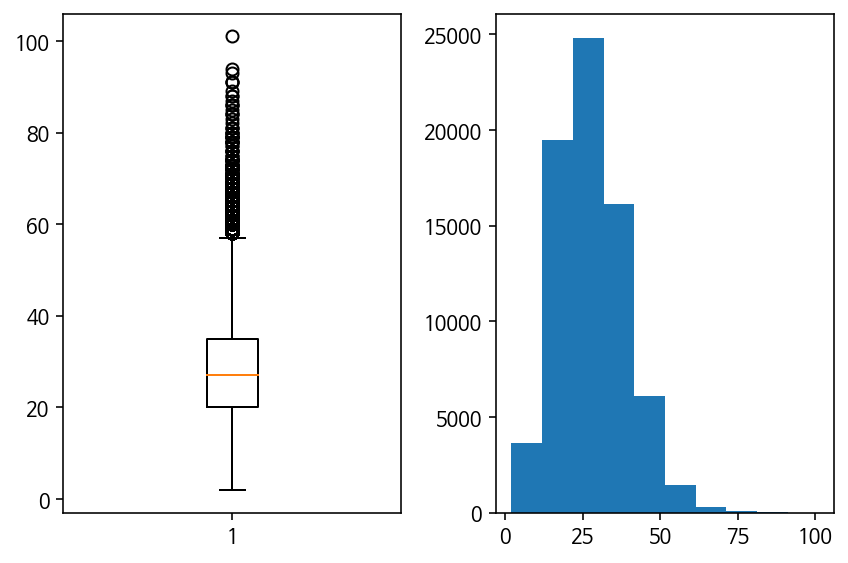

In [25]:
eng_token_len = [len(s.split()) for s in cleaned_eng]

print('영어 토큰의 최소 길이 : {}'.format(np.min(eng_token_len)))
print('영어 토큰의 최대 길이 : {}'.format(np.max(eng_token_len)))
print('영어 토큰의 평균 길이 : {}'.format(np.mean(eng_token_len)))

plt.subplot(1,2,1)
plt.boxplot(eng_token_len)
plt.subplot(1,2,2)
plt.hist(eng_token_len)
plt.tight_layout()
plt.show()

한국어 토큰의 최소 길이 : 0
한국어 토큰의 최대 길이 : 127
한국어 토큰의 평균 길이 : 30.398580318942045


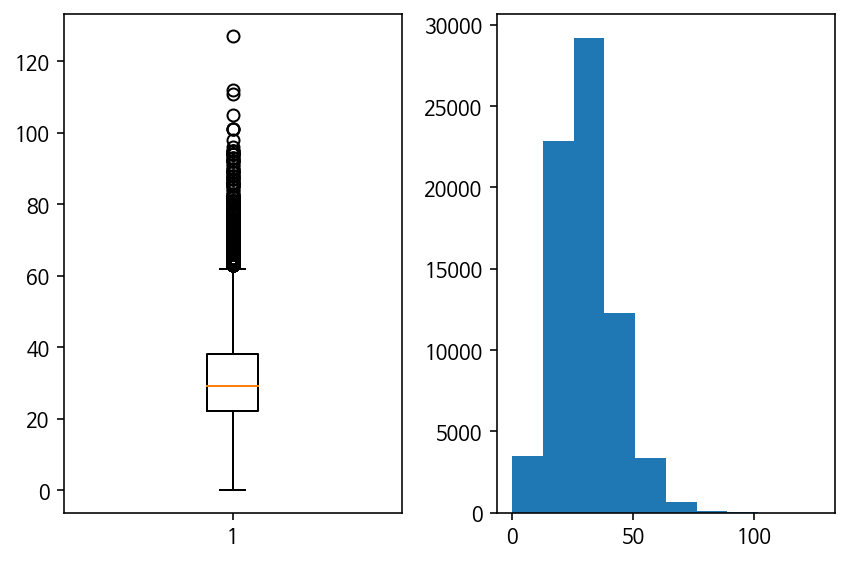

In [26]:
from konlpy.tag import Mecab
kor_tokenizer = Mecab()

kor_token_len = [ len(kor_tokenizer.morphs(s)) for s in cleaned_kor]

print('한국어 토큰의 최소 길이 : {}'.format(np.min(kor_token_len)))
print('한국어 토큰의 최대 길이 : {}'.format(np.max(kor_token_len)))
print('한국어 토큰의 평균 길이 : {}'.format(np.mean(kor_token_len)))

plt.subplot(1,2,1)
plt.boxplot(kor_token_len)
plt.subplot(1,2,2)
plt.hist(kor_token_len)
plt.tight_layout()
plt.show()

In [27]:
kor_corpus = []
eng_corpus = []

for kor, eng in zip(cleaned_kor, cleaned_eng):
    len_eng = len(eng.split())
    len_kor = len(kor_tokenizer.morphs(kor))
    
    if len_eng <= 40 and len_kor <= 40:
        kor_corpus.append(kor)
        eng_corpus.append(eng)

In [28]:
# 확인
kor_token_len = [ len(kor_tokenizer.morphs(s)) for s in kor_corpus]
print('한국어 토큰의 최대 길이 : {}'.format(np.max(kor_token_len)))

eng_token_len = [len(s.split()) for s in eng_corpus]
print('영어 토큰의 최대 길이 : {}'.format(np.max(eng_token_len)))

한국어 토큰의 최대 길이 : 40
영어 토큰의 최대 길이 : 40


In [29]:
len(kor_corpus), len(eng_corpus)

(55121, 55121)

## 토큰화

In [30]:
def eng_tokenize(eng_corpus, num_words=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)  # 공백으로 split이 내부 동작
    tokenizer.fit_on_texts(eng_corpus)

    tensor = tokenizer.texts_to_sequences(eng_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [31]:
def kor_tokenize(kor_corpus, num_words=None):
    mecab = Mecab()
    
    mecab_corpus = [mecab.morphs(s) for s in kor_corpus]
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    tokenizer.fit_on_texts(mecab_corpus)

    tensor = tokenizer.texts_to_sequences(mecab_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer
    

In [32]:
enc_tensor_none, enc_tokenizer_none  = kor_tokenize(kor_corpus)
dec_tensor_none, dec_tokenizer_none = eng_tokenize(eng_corpus)

In [33]:
print(len(enc_tokenizer_none.index_word))
print(len(dec_tokenizer_none.index_word))

42116
38700


In [34]:
enc_tensor_10000, enc_tokenizer_10000  = kor_tokenize(kor_corpus, 10000)
dec_tensor_10000, dec_tokenizer_10000 = eng_tokenize(eng_corpus, 10000)

In [35]:
enc_tensor_20000, enc_tokenizer_20000  = kor_tokenize(kor_corpus, 20000)
dec_tensor_20000, dec_tokenizer_20000 = eng_tokenize(eng_corpus, 20000)

In [36]:
enc_tensor_30000, enc_tokenizer_30000  = kor_tokenize(kor_corpus, 30000)
dec_tensor_30000, dec_tokenizer_30000 = eng_tokenize(eng_corpus, 30000)

## 모델 설계

In [37]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [38]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules
        self.enc_units = enc_units

        # Embedding Layer
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        # GRU Layer
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True)


    def call(self, x):
        # TODO: Awesome Process
        x = self.embedding(x)
        whole_sequence_output, final_state = self.gru(x)
        return whole_sequence_output, final_state

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out, initial_state= h_dec)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn


## 훈련

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')     

def loss_function(real, pred):
    # tf.math.equal -> element-wise 비교; True, False 리턴;
    # logic_not -> 논리 not 연산;
    # padding이 아닌 실제 토큰 위치는 True, PAD는 False
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # loss_object는 SparseCategoricalCrossentropy의 인스턴스 (글로벌로 정의된 것)
    loss = loss_object(real, pred)
    
    # mask는 True, False로 되어있고, loss는 실수형이므로 타입 변경
    mask = tf.cast(mask, dtype=loss.dtype)
    # loss 텐서에서 padding 위치는 0으로, 나머지는 그대로 유지 -> PAD 토큰의 손실은 0이 되며 무시됨
    loss *= mask
    
    # tf.reduce_mean(input_tensor, axis=None, keepdims=False)
    return tf.reduce_mean(loss) # 마스크된 loss를 평균 내어 최종 loss 계산 -> 유효한 토큰들만 평균 (PAD 제외)


In [62]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out, h_dec = encoder(src)      # encoder의 출력은 context vector, final_state를 출력으로 받음
        # h_dec = enc_out[:, -1]      # encoder의 마지막 hidden state를 decoder의 초기 hidden state로 사용
        
        # 디코더는 한 time step씩 입력을 받으므로, shape은 (batch_size, 1) 여야 함
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        # <start> 토큰을 제외한 나머지 단어들에 대해 반복; 예측은 두 번째 토큰부터 비교하기 때문
        for t in range(1, tgt.shape[1]):
            # pred: 다음 토큰 예측; h_dec: update된 hidden state
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            # tgt[:, t]는 현재 time step의 정답 토큰; pred는 예측한 토큰; loss: 전체 시퀀스 손실 누적
            loss += loss_function(tgt[:, t], pred)
            # 다음 스텝의 디코더 입력을 **예측값(pred)**이 아닌, 실제 정답(tgt)을 입력으로 사용; 교사강요(teacher forcing)
            # 교사강요는 디코더가 예측한 값이 아닌, 실제 정답을 다음 time step의 입력으로 사용하여 학습하는 기법
            dec_src = tf.expand_dims(tgt[:, t], 1)
    
    # 시퀀스 loss 평균
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [43]:
def train_model(enc_tensor, dec_tensor,
                batch_size, src_vocab_size,
                tgt_vocab_size,units,
                embedding_dim, optimizer, 
                dec_tokenizer,  epochs,
               encoder, decoder):
    

    
    train_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        
        idx_list = list(range(0, enc_tensor.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        
        for (batch, idx) in enumerate(t):
            batch_loss = train_step(enc_tensor[idx:idx+batch_size],
                                dec_tensor[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
            
            total_loss += batch_loss
            
            t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
        
        avg_loss = total_loss / (batch + 1)
        train_losses.append(avg_loss)
        
    
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return encoder, decoder
    
    

Epoch 20: 100%|██████████| 862/862 [02:11<00:00,  6.55it/s, Loss 0.9679]


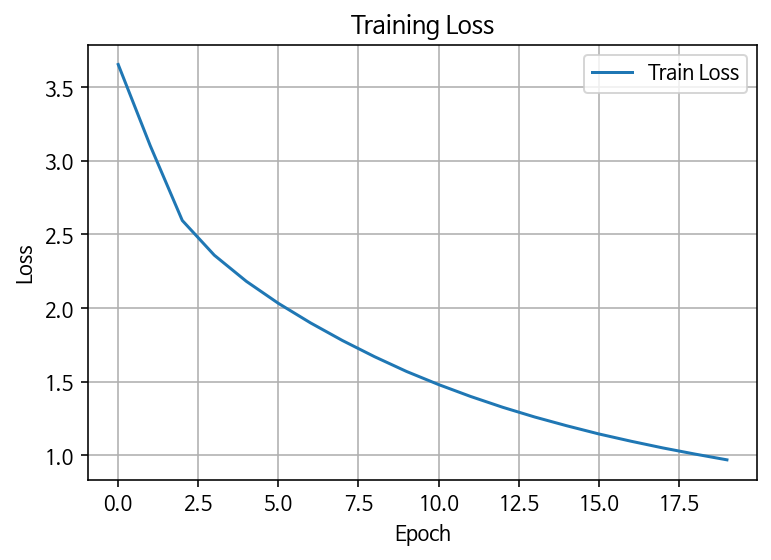

In [53]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 10000
TGT_VOCAB_SIZE = 10000

units         = 512
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    
encoder, decoder = train_model(enc_tensor=enc_tensor_10000,
            dec_tensor=dec_tensor_10000,
            batch_size=BATCH_SIZE,
            src_vocab_size=SRC_VOCAB_SIZE,
            tgt_vocab_size=TGT_VOCAB_SIZE,
            units=units,
            embedding_dim=embedding_dim,
            optimizer=optimizer,
            dec_tokenizer=dec_tokenizer_10000,
            epochs=20,
            encoder=encoder,
            decoder=decoder
           )

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

def evaluate(sentence, encoder, decoder, 
             enc_tokenizer, dec_tokenizer, 
             max_enc_len, max_dec_len):
    
    attention = np.zeros((max_dec_len, max_enc_len))
    
    # 전처리 및 토큰화
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_enc_len,
                                                           padding='post')

    result = ''
    enc_out, dec_hidden = encoder(inputs)

    
#     dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(max_dec_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = dec_tokenizer.index_word.get(predicted_id, '<unk>')
        result += predicted_word + ' '

        if predicted_word == '<end>':
            return result.strip(), sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip(), sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder, 
              enc_tokenizer, dec_tokenizer, 
              max_enc_len, max_dec_len):
    
    result, processed_sentence, attention = evaluate(
        sentence, encoder, decoder,
        enc_tokenizer, dec_tokenizer,
        max_enc_len, max_dec_len
    )

    print('Input: %s' % processed_sentence)
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(processed_sentence.split())]
    plot_attention(attention, processed_sentence.split(), result.split())


#### tokenizer 10000, embedding 10000

Input: 커피는 필요 없다 .
Predicted translation: i wasn t obvious . <end>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


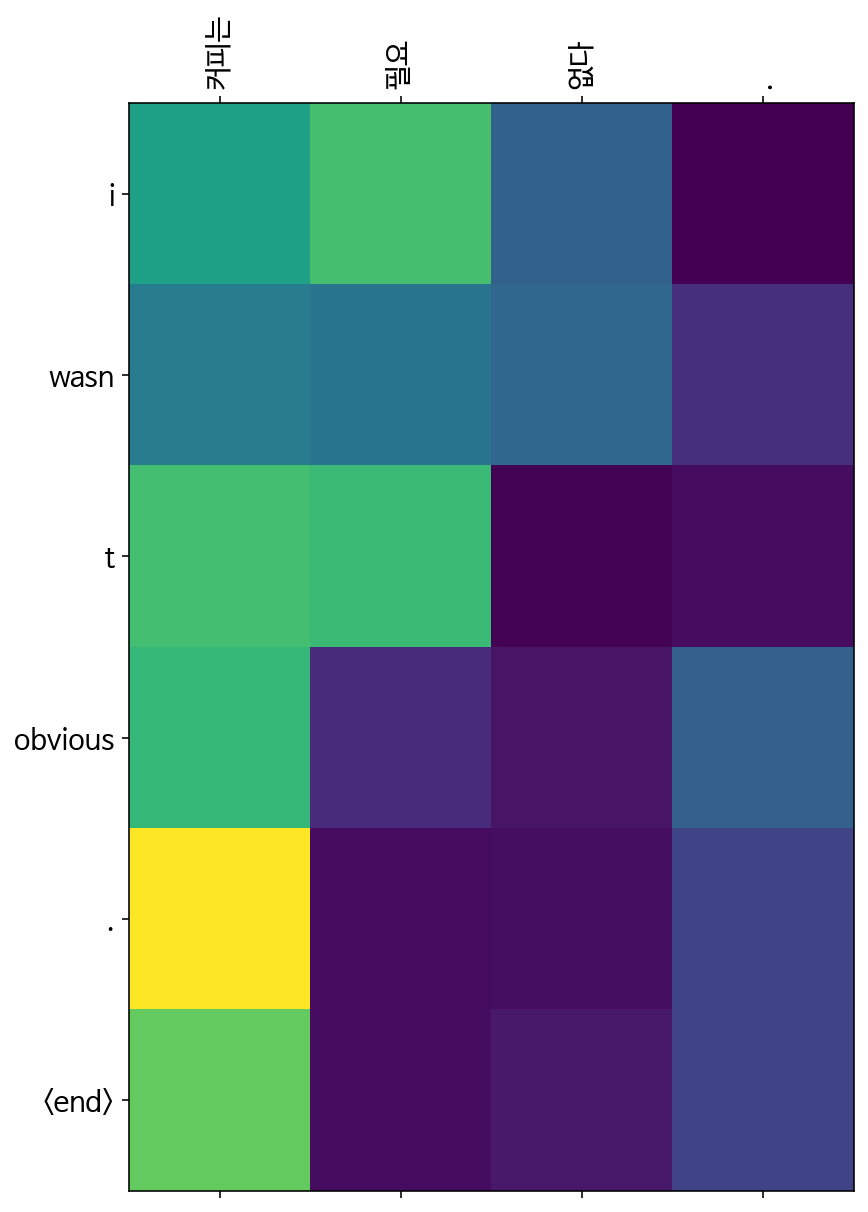

In [55]:
translate(
    "커피는 필요 없다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_10000,
    dec_tokenizer=dec_tokenizer_10000,
    max_enc_len=enc_tensor_10000.shape[1],
    max_dec_len=dec_tensor_10000.shape[1]
)


필요 없다 -> wasn't 으로 attention을 진행한 부분 어느정도 합리적으로 보이나, 적절한 단어로 번역했다고는 볼 수 없다.  
vocab_size=10000은 표현을 충분히 하기에는 부족한 size 라고 판단할 수 있다.  

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: seven seven seven seven seven seven seven <end>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


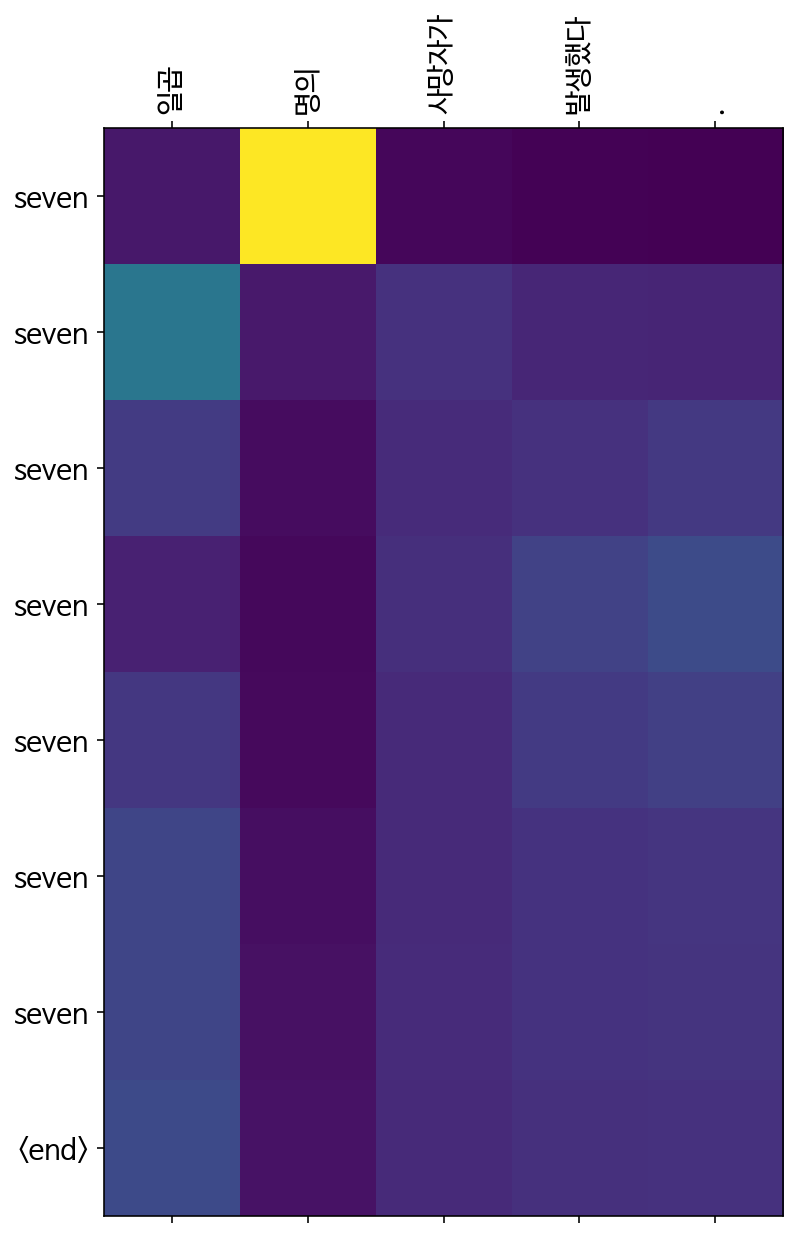

In [57]:
translate(
    "일곱 명의 사망자가 발생했다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_10000,
    dec_tokenizer=dec_tokenizer_10000,
    max_enc_len=enc_tensor_10000.shape[1],
    max_dec_len=dec_tensor_10000.shape[1]
)


vocab size를 10000으로 해서 그런지, 이 번역은 특히 매칭되는 단어를 찾지 못한 것처럼 보인다.

Input: 시민들은 도시 속에 산다 .
Predicted translation: the city is . <end>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


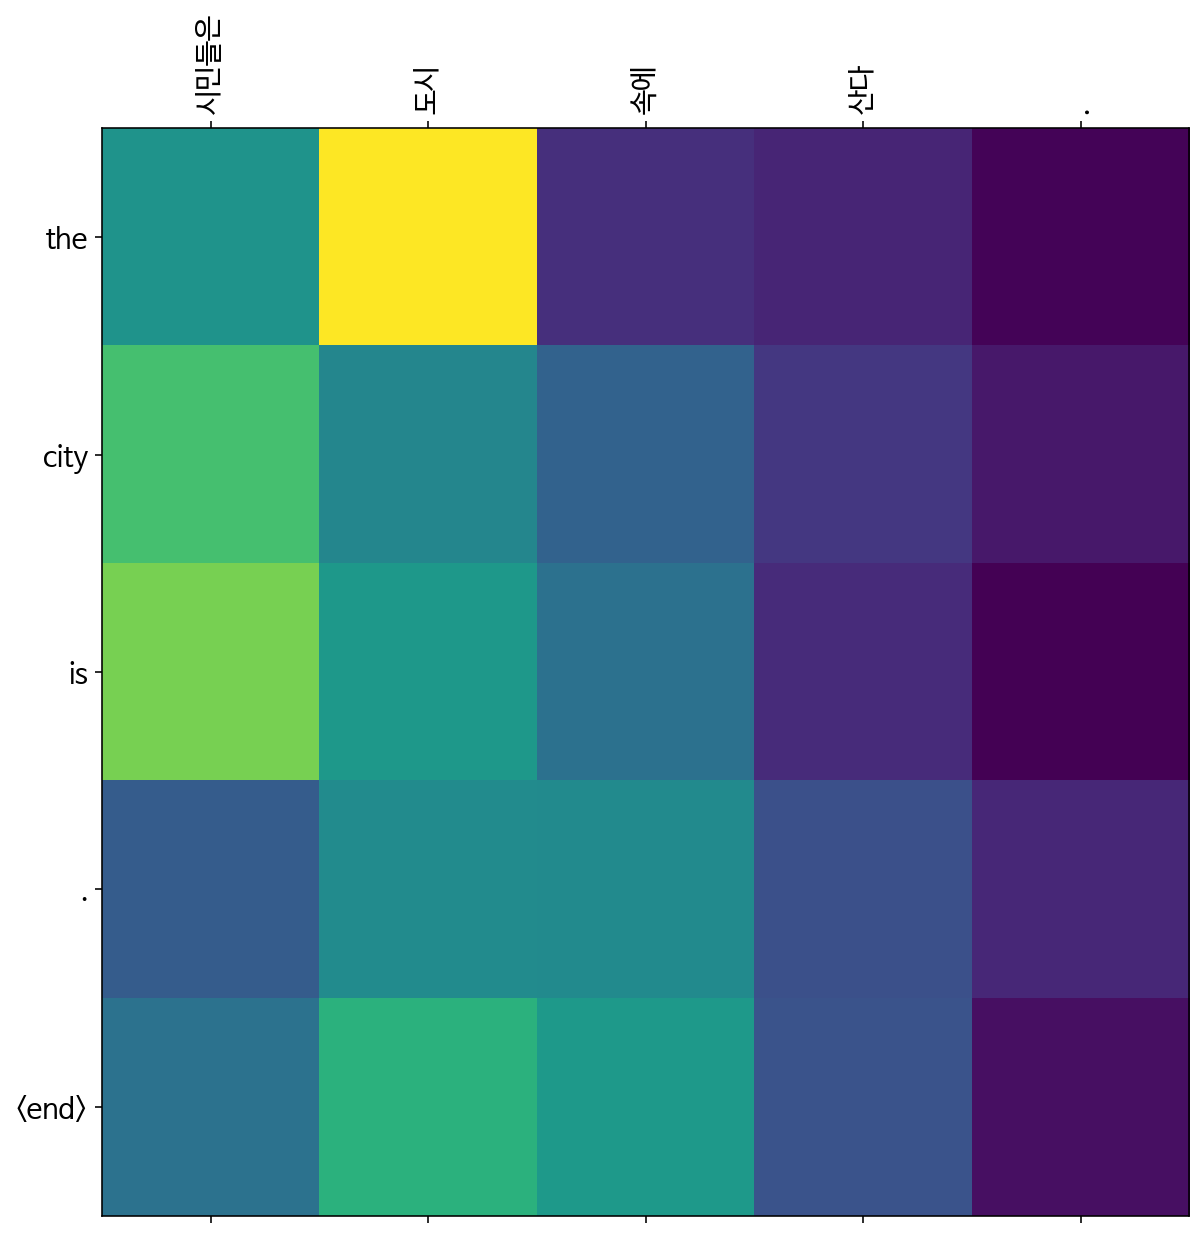

In [58]:
translate(
    "시민들은 도시 속에 산다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_10000,
    dec_tokenizer=dec_tokenizer_10000,
    max_enc_len=enc_tensor_10000.shape[1],
    max_dec_len=dec_tensor_10000.shape[1]
)


Input: 오바마는 대통령이다 .
Predicted translation: . <end>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


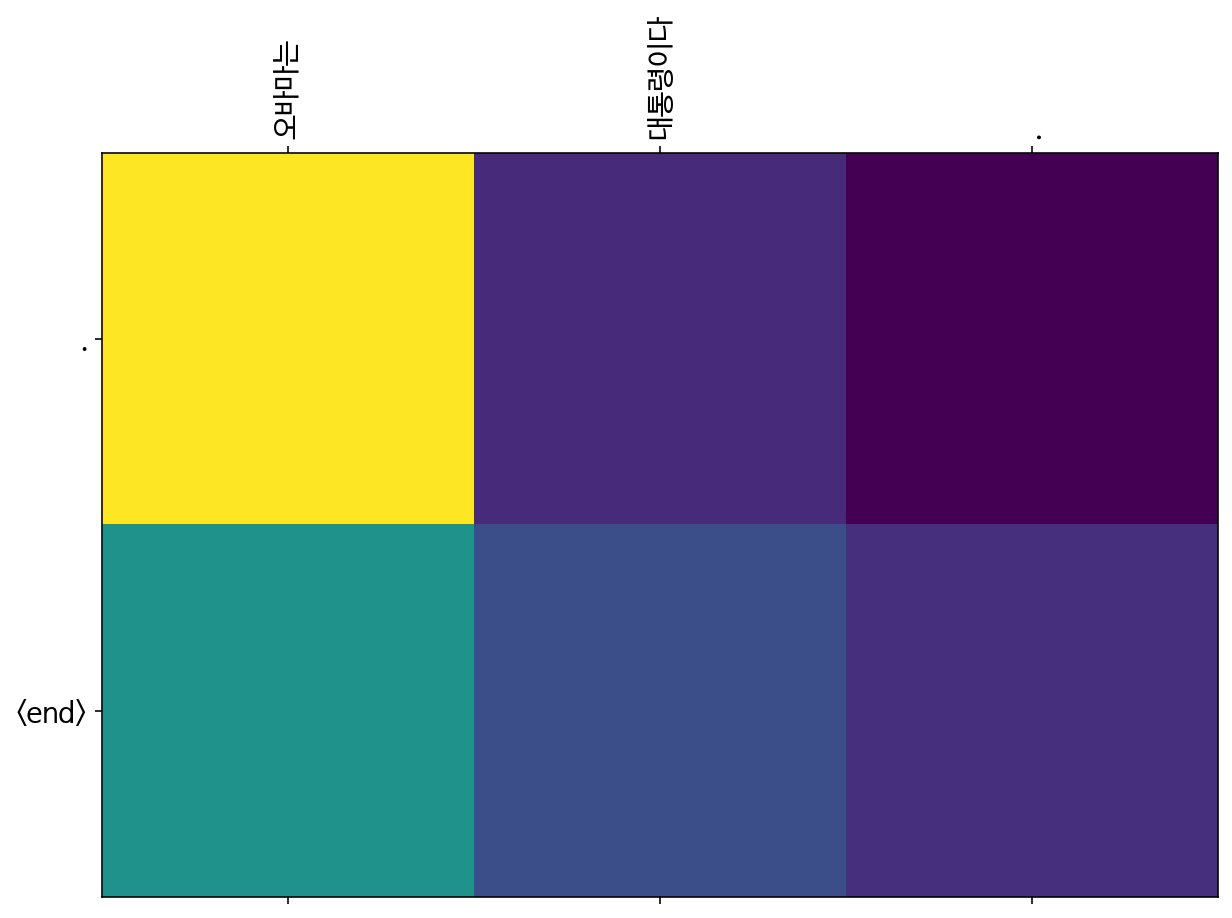

In [60]:
translate(
    "오바마는 대통령이다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_10000,
    dec_tokenizer=dec_tokenizer_10000,
    max_enc_len=enc_tensor_10000.shape[1],
    max_dec_len=dec_tensor_10000.shape[1]
)


고유 명사를 제대로 번역하지 못한 것을 확인할 수 있다. 

### 단어사전: none, 임베딩 vocab_size=30000

Epoch 20: 100%|██████████| 862/862 [02:56<00:00,  4.90it/s, Loss nan]
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


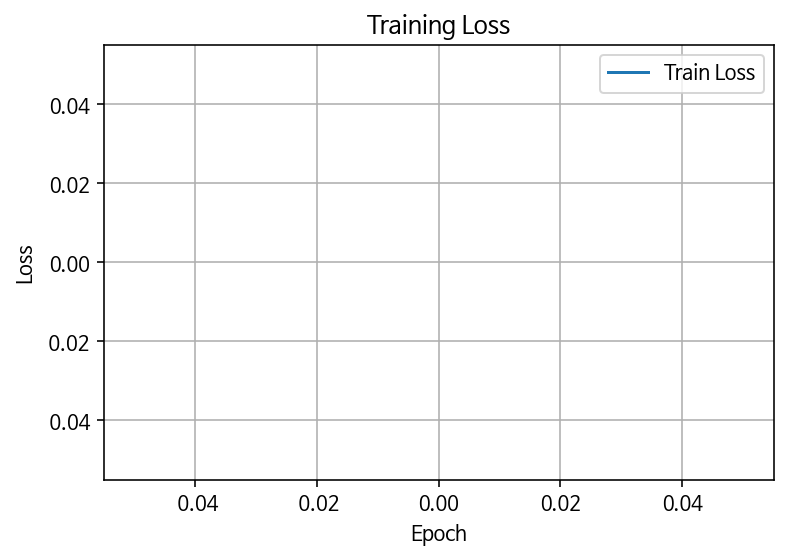

In [63]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 30000
TGT_VOCAB_SIZE = 30000

units         = 512
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    
encoder, decoder = train_model(enc_tensor=enc_tensor_none,
            dec_tensor=dec_tensor_none,
            batch_size=BATCH_SIZE,
            src_vocab_size=SRC_VOCAB_SIZE,
            tgt_vocab_size=TGT_VOCAB_SIZE,
            units=units,
            embedding_dim=embedding_dim,
            optimizer=optimizer,
            dec_tokenizer=dec_tokenizer_none,
            epochs=20,
            encoder=encoder,
            decoder=decoder
           )

Input: 커피는 필요 없다 .
Predicted translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/opt/conda/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


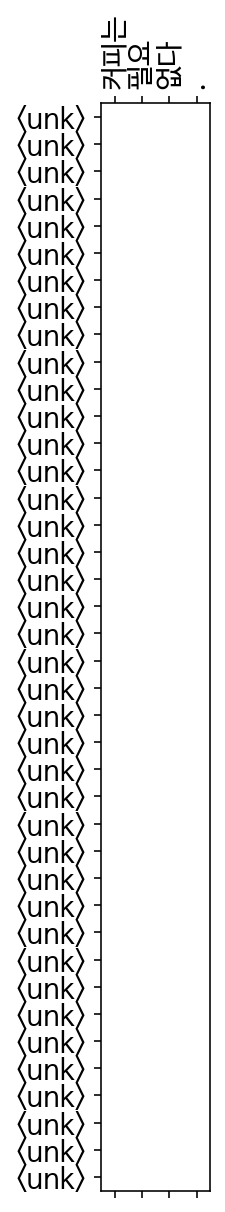

In [64]:
translate(
    "커피는 필요 없다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_none,
    dec_tokenizer=dec_tokenizer_none,
    max_enc_len=enc_tensor_none.shape[1],
    max_dec_len=dec_tensor_none.shape[1]
)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


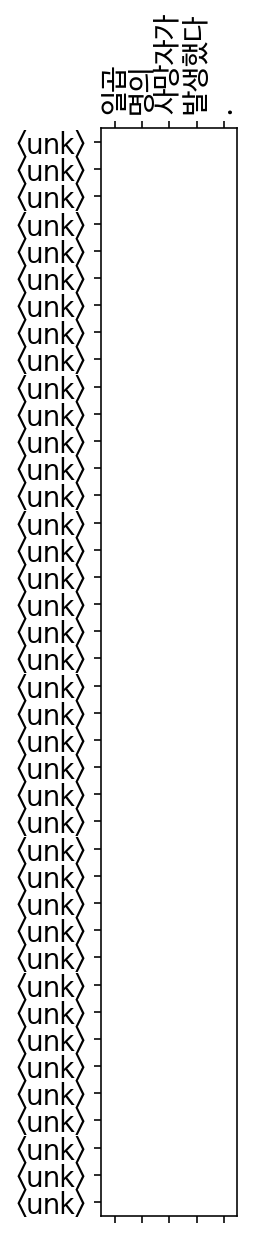

In [65]:
translate(
    "일곱 명의 사망자가 발생했다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_none,
    dec_tokenizer=dec_tokenizer_none,
    max_enc_len=enc_tensor_none.shape[1],
    max_dec_len=dec_tensor_none.shape[1]
)

Input: 시민들은 도시 속에 산다 .
Predicted translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


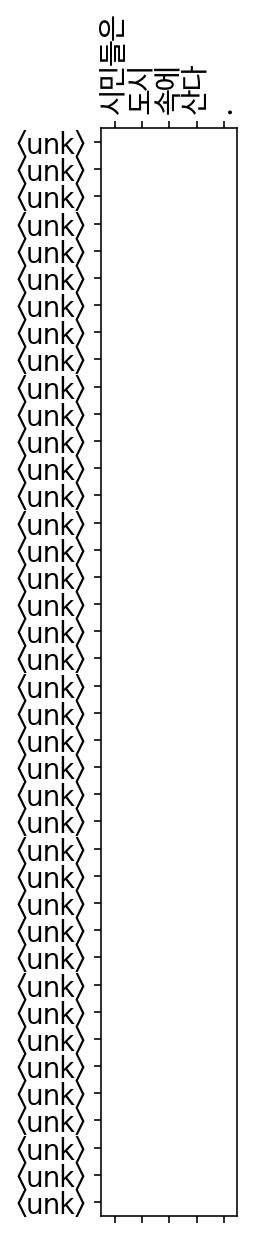

In [66]:
translate(
    "시민들은 도시 속에 산다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_none,
    dec_tokenizer=dec_tokenizer_none,
    max_enc_len=enc_tensor_none.shape[1],
    max_dec_len=dec_tensor_none.shape[1]
)

Input: 오바마는 대통령이다 .
Predicted translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


/tmp/ipykernel_263/2254222930.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_263/2254222930.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


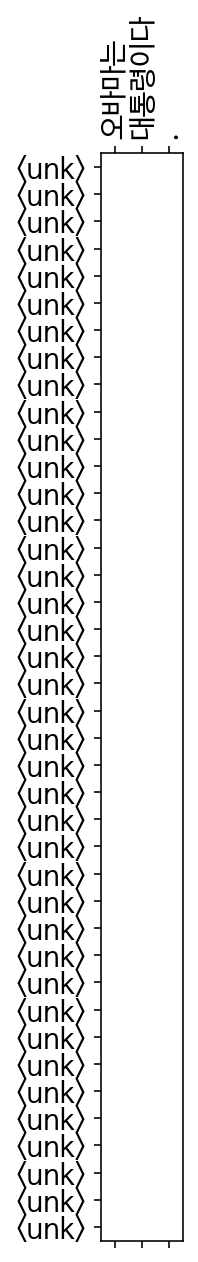

In [67]:
translate(
    "오바마는 대통령이다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_none,
    dec_tokenizer=dec_tokenizer_none,
    max_enc_len=enc_tensor_none.shape[1],
    max_dec_len=dec_tensor_none.shape[1]
)

한국어 42116, 영어 38700 의 모든 토큰을 다 사용하고, embedding vocab size를 30000으로 한 경우, 학습이 되지 않았다.    

**token vocab size와 embedding vocab size가 달라서 학습이 제대로 이루어 지지 않은 것 같다**

### token: 30000, embedding: 30000

In [47]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out, h_dec = encoder(src)      # encoder의 출력은 context vector, final_state를 출력으로 받음
        # h_dec = enc_out[:, -1]      # encoder의 마지막 hidden state를 decoder의 초기 hidden state로 사용
        
        # 디코더는 한 time step씩 입력을 받으므로, shape은 (batch_size, 1) 여야 함
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        # <start> 토큰을 제외한 나머지 단어들에 대해 반복; 예측은 두 번째 토큰부터 비교하기 때문
        for t in range(1, tgt.shape[1]):
            # pred: 다음 토큰 예측; h_dec: update된 hidden state
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            # tgt[:, t]는 현재 time step의 정답 토큰; pred는 예측한 토큰; loss: 전체 시퀀스 손실 누적
            loss += loss_function(tgt[:, t], pred)
            # 다음 스텝의 디코더 입력을 **예측값(pred)**이 아닌, 실제 정답(tgt)을 입력으로 사용; 교사강요(teacher forcing)
            # 교사강요는 디코더가 예측한 값이 아닌, 실제 정답을 다음 time step의 입력으로 사용하여 학습하는 기법
            dec_src = tf.expand_dims(tgt[:, t], 1)
    
    # 시퀀스 loss 평균
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 30000
TGT_VOCAB_SIZE = 30000

units         = 512
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    
encoder, decoder = train_model(enc_tensor=enc_tensor_30000,
            dec_tensor=dec_tensor_30000,
            batch_size=BATCH_SIZE,
            src_vocab_size=SRC_VOCAB_SIZE,
            tgt_vocab_size=TGT_VOCAB_SIZE,
            units=units,
            embedding_dim=embedding_dim,
            optimizer=optimizer,
            dec_tokenizer=dec_tokenizer_30000,
            epochs=20,
            encoder=encoder,
            decoder=decoder
           )

Epoch  7:  17%|█▋        | 150/862 [00:34<02:42,  4.37it/s, Loss 1.9099]

In [ ]:
translate(
    "커피는 필요 없다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_30000,
    dec_tokenizer=dec_tokenizer_30000,
    max_enc_len=enc_tensor_30000.shape[1],
    max_dec_len=dec_tensor_30000.shape[1]
)

translate(
    "일곱 명의 사망자가 발생했다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_30000,
    dec_tokenizer=dec_tokenizer_30000,
    max_enc_len=enc_tensor_30000.shape[1],
    max_dec_len=dec_tensor_30000.shape[1]
)

translate(
    "시민들은 도시 속에 산다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_30000,
    dec_tokenizer=dec_tokenizer_30000,
    max_enc_len=enc_tensor_30000.shape[1],
    max_dec_len=dec_tensor_30000.shape[1]
)

translate(
    "오바마는 대통령이다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_30000,
    dec_tokenizer=dec_tokenizer_30000,
    max_enc_len=enc_tensor_30000.shape[1],
    max_dec_len=dec_tensor_30000.shape[1]
)

### 20000

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out, h_dec = encoder(src)      # encoder의 출력은 context vector, final_state를 출력으로 받음
        # h_dec = enc_out[:, -1]      # encoder의 마지막 hidden state를 decoder의 초기 hidden state로 사용
        
        # 디코더는 한 time step씩 입력을 받으므로, shape은 (batch_size, 1) 여야 함
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        # <start> 토큰을 제외한 나머지 단어들에 대해 반복; 예측은 두 번째 토큰부터 비교하기 때문
        for t in range(1, tgt.shape[1]):
            # pred: 다음 토큰 예측; h_dec: update된 hidden state
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            # tgt[:, t]는 현재 time step의 정답 토큰; pred는 예측한 토큰; loss: 전체 시퀀스 손실 누적
            loss += loss_function(tgt[:, t], pred)
            # 다음 스텝의 디코더 입력을 **예측값(pred)**이 아닌, 실제 정답(tgt)을 입력으로 사용; 교사강요(teacher forcing)
            # 교사강요는 디코더가 예측한 값이 아닌, 실제 정답을 다음 time step의 입력으로 사용하여 학습하는 기법
            dec_src = tf.expand_dims(tgt[:, t], 1)
    
    # 시퀀스 loss 평균
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000

units         = 512
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    
encoder, decoder = train_model(enc_tensor=enc_tensor_20000,
            dec_tensor=dec_tensor_20000,
            batch_size=BATCH_SIZE,
            src_vocab_size=SRC_VOCAB_SIZE,
            tgt_vocab_size=TGT_VOCAB_SIZE,
            units=units,
            embedding_dim=embedding_dim,
            optimizer=optimizer,
            dec_tokenizer=dec_tokenizer_20000,
            epochs=20,
            encoder=encoder,
            decoder=decoder
           )

In [ ]:
translate(
    "커피는 필요 없다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_20000,
    dec_tokenizer=dec_tokenizer_20000,
    max_enc_len=enc_tensor_20000.shape[1],
    max_dec_len=dec_tensor_20000.shape[1]
)

translate(
    "일곱 명의 사망자가 발생했다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_20000,
    dec_tokenizer=dec_tokenizer_20000,
    max_enc_len=enc_tensor_20000.shape[1],
    max_dec_len=dec_tensor_20000.shape[1]
)

translate(
    "시민들은 도시 속에 산다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_20000,
    dec_tokenizer=dec_tokenizer_20000,
    max_enc_len=enc_tensor_20000.shape[1],
    max_dec_len=dec_tensor_20000.shape[1]
)

translate(
    "오바마는 대통령이다.",
    encoder,
    decoder,
    enc_tokenizer=enc_tokenizer_20000,
    dec_tokenizer=dec_tokenizer_20000,
    max_enc_len=enc_tensor_20000.shape[1],
    max_dec_len=dec_tensor_20000.shape[1]
)

# 회고

처음에 모델 설계에서는 번역이 'the' 토큰만 반복되는 문장만 출력됐었는데,  
인코더의 `whole_sequence_output, final_state = self.gru(x)`,
디코더의 `out, h_dec = self.gru(out, initial_state= h_dec)`,   
모델 학습에서 
```
enc_out, h_dec = encoder(src)      # encoder의 출력은 context vector, final_state를 출력으로 받음
# h_dec = enc_out[:, -1]      # 이 코드 대신에서 위의 방식을 사용
```
이 부분을 변경하니, 제대로 동작했다.  

    
    

vocab size를 10000으로 한 경우에는, 입력 단어에 매칭되는 출력단어가 부족한 것 같아, 번역 성능이 떨어진 것 같다.  



정량적 평가 방법을 추가하면 좋을 것 같다. 
